## Load images from files

In [172]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import functional as F

In [2]:
kong_images = torch.load('kong-images.pth')

C:\Users\irvin\AppData\Local\Temp\ipykernel_6928\436598526.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kong_images = torch.load('kong-images.pth')


In [3]:
no_kong_images = torch.load('no-kong-images.pth')

C:\Users\irvin\AppData\Local\Temp\ipykernel_6928\3030559923.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  no_kong_images = torch.load('no-kong-images.pth')


In [4]:
kong_images.shape

torch.Size([1016, 224, 224, 3])

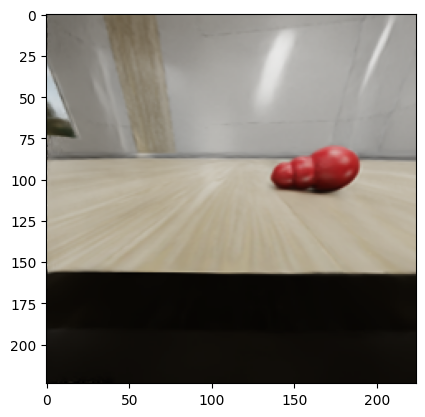

In [5]:
sample_image = kong_images[400]
plt.imshow(sample_image.cpu().numpy())
plt.show()

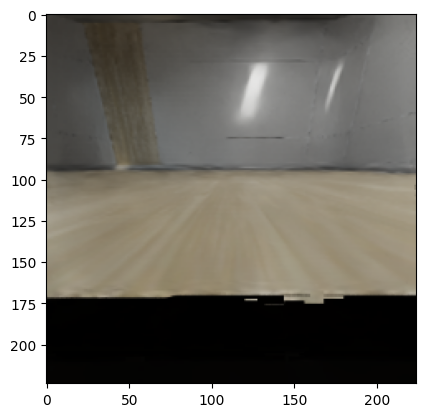

In [6]:
sample_image = no_kong_images[10]
plt.imshow(sample_image.cpu().numpy())
plt.show()

## Create datasets from image tensors

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset

In [8]:


class ImageTensorDataset(Dataset):
    def __init__(self, image_tensor, labels=None, transform=None):
        self.image_tensor = image_tensor
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_tensor)

    def __getitem__(self, idx):
        image = self.image_tensor[idx]
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image


The neural network expects the channel number to come first so permute the columns in the image tensor

In [124]:
def permute_columns(image_tensor):
    return image_tensor.permute([2, 0, 1])

def make_float(image_tensor):
    return image_tensor/1.0

In [150]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Compute the mean and standard deviation for normalization

In [145]:
all_images = torch.cat([kong_images, no_kong_images], dim=0)
all_images.shape

torch.Size([2024, 224, 224, 3])

In [147]:
normalization_dataset = ImageTensorDataset(all_images, torch.zeros(len(all_images)))

In [152]:
mean = torch.zeros(3).to(device)  # Assuming 3 channels (RGB)
std = torch.zeros(3).to(device)
for img, _ in normalization_dataset:
    img = img/1.0
    for i in range(3):  # Iterate over the channels
        mean[i] += img[i, :, :].mean()
        std[i] += img[i, :, :].std()

mean /= len(normalization_dataset)
std /= len(normalization_dataset)

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([136.3714, 136.5949, 136.9134], device='cuda:0')
Std: tensor([29.0595, 28.8172, 28.8296], device='cuda:0')


In [153]:
from torchvision.transforms import v2
transform = v2.Compose([
    permute_columns,
    make_float,
    # means and standard deviations widely used from imagenet
    v2.Normalize(mean=mean, std=std)
])

In [154]:
transform(sample_image)

tensor([[[-2.5249, -2.5249, -2.5593,  ..., -0.3225, -0.3225, -0.3225],
         [-2.5249, -2.5249, -2.5593,  ..., -0.3569, -0.3225, -0.3225],
         [-2.5249, -2.5249, -2.5593,  ..., -0.3569, -0.2881, -0.2881],
         ...,
         [-4.5552, -4.5552, -4.5552,  ..., -4.5896, -4.5896, -4.5896],
         [-4.5552, -4.5552, -4.5552,  ..., -4.5896, -4.5896, -4.5896],
         [-4.5552, -4.5552, -4.5552,  ..., -4.5896, -4.5896, -4.5896]],

        [[-2.6580, -2.6580, -2.6580,  ..., -0.3677, -0.3677, -0.3330],
         [-2.6233, -2.6580, -2.6580,  ..., -0.4024, -0.3330, -0.3330],
         [-2.6233, -2.6580, -2.6927,  ..., -0.3677, -0.3330, -0.3330],
         ...,
         [-4.6012, -4.6012, -4.6359,  ..., -4.6359, -4.6359, -4.6359],
         [-4.6012, -4.6012, -4.6359,  ..., -4.6359, -4.6359, -4.6359],
         [-4.6012, -4.6012, -4.6359,  ..., -4.6359, -4.6359, -4.6359]],

        [[-2.8066, -2.8066, -2.8066,  ..., -0.4479, -0.4479, -0.4479],
         [-2.8066, -2.8066, -2.8066,  ..., -0

In [136]:
from torchvision.gallery.transforms import helpers

ModuleNotFoundError: No module named 'torchvision.gallery'

In [117]:
sample_image/1.0

tensor([[[ 63.,  60.,  56.],
         [ 63.,  60.,  56.],
         [ 62.,  60.,  56.],
         ...,
         [127., 126., 124.],
         [127., 126., 124.],
         [127., 127., 124.]],

        [[ 63.,  61.,  56.],
         [ 63.,  60.,  56.],
         [ 62.,  60.,  56.],
         ...,
         [126., 125., 123.],
         [127., 127., 124.],
         [127., 127., 124.]],

        [[ 63.,  61.,  57.],
         [ 63.,  60.,  56.],
         [ 62.,  59.,  55.],
         ...,
         [126., 126., 123.],
         [128., 127., 124.],
         [128., 127., 124.]],

        ...,

        [[  4.,   4.,   3.],
         [  4.,   4.,   3.],
         [  4.,   3.,   3.],
         ...,
         [  3.,   3.,   2.],
         [  3.,   3.,   2.],
         [  3.,   3.,   2.]],

        [[  4.,   4.,   3.],
         [  4.,   4.,   3.],
         [  4.,   3.,   3.],
         ...,
         [  3.,   3.,   2.],
         [  3.,   3.,   2.],
         [  3.,   3.,   2.]],

        [[  4.,   4.,   3.],
       

In [156]:
has_kong_dataset = ImageTensorDataset(kong_images, torch.ones(len(kong_images)), transform)

In [157]:
no_kong_dataset = ImageTensorDataset(no_kong_images, torch.zeros(len(no_kong_images)), transform)

In [158]:
total_kong_dataset = ConcatDataset([has_kong_dataset, no_kong_dataset])

In [159]:
from torch.utils.data import DataLoader

In [160]:
dataloader = DataLoader(total_kong_dataset, batch_size=4, shuffle=True)

In [161]:
dataiter = iter(dataloader)

images, labels = next(dataiter)

In [189]:
def unpermute_columns(image_tensor):
    return image_tensor.permute([1, 2, 0])

def make_byte(image_tensor):
    return F.to_dtype(image_tensor, torch.uint8)
    
# from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/21
class UnNormalize(torchvision.transforms.Normalize):
    def __init__(self,mean,std,*args,**kwargs):
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)


In [190]:
untransform = v2.Compose([
    UnNormalize(mean=mean, std=std),
    make_byte,
    unpermute_columns
])    

In [192]:
untransform(images[3]).shape
#images[3].shape

torch.Size([224, 224, 3])

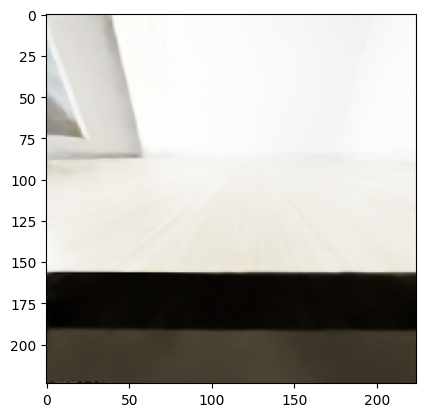

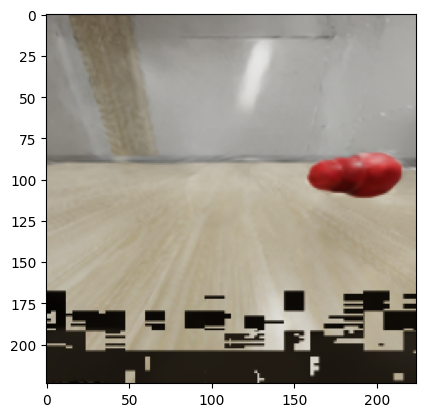

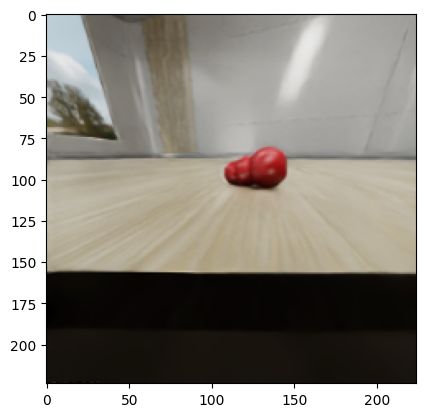

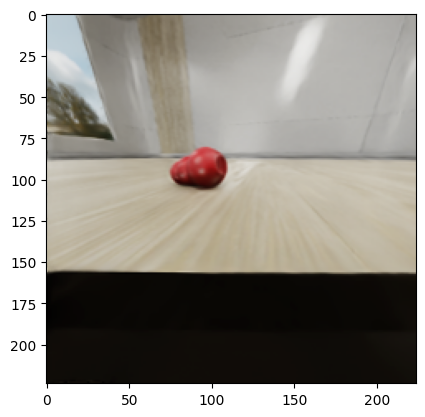

In [193]:
for i in images:
    plt.imshow(untransform(i).cpu().numpy())
    plt.show()
    

In [17]:
images.shape

torch.Size([4, 3, 224, 224])

## Define the network, loss, and optimizer

In [18]:
import torch.nn as nn
import torch.optim as optim

In [19]:
class KongClassifier(nn.Module):
    def __init__(self):
        super(KongClassifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.mlp = nn.Sequential(
            nn.Linear(64*24*24, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        features = self.cnn(input)
        flattened_features = features.view(-1, 64*24*24)
        output = self.mlp(flattened_features)
        return output

                
        


In [102]:
network = KongClassifier()

In [104]:
network.to(device)

KongClassifier(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=36864, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [105]:
# specify loss function (categorical cross-entropy)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.SGD(network.parameters(), lr=0.01)

In [69]:
for i in range(4):
    output = network(images[i]/1.0)
    label = labels[i]
    print(f'{output.item()}  {label} {criterion(output[0][0], label.to(device))}')

0.012477154843509197  0.0 0.012555648572742939
0.018672814592719078  1.0 3.980686664581299
0.012477154843509197  0.0 0.012555648572742939
0.012474117800593376  1.0 4.38409948348999


## Train the network

In [75]:
import torchvision

### Visualization using Tensorboard

Following https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

In [71]:
from torch.utils.tensorboard import SummaryWriter

In [101]:
writer = SummaryWriter('runs/kong_classification_analysis4')

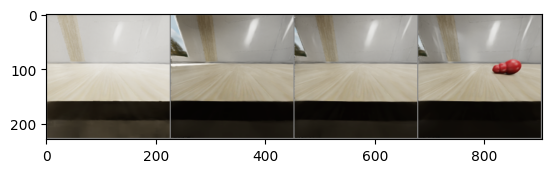

In [194]:
dataiter = iter(dataloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

plt.imshow(untransform(img_grid).cpu().numpy())

# write to tensorboard
writer.add_image('four_kong_images', img_grid)

In [57]:
writer.add_graph(network, images/1.0)

In [58]:
writer.close()

In [59]:
images.shape

torch.Size([4, 3, 224, 224])

In [60]:
images.shape

torch.Size([4, 3, 224, 224])

In [61]:
features = torch.flatten(images, start_dim=1)
features.shape

torch.Size([4, 150528])

In [62]:
classes = ['no kong', 'kong']
class_labels = [classes[int(label)] for label in labels]

In [63]:
class_labels

['kong', 'no kong', 'no kong', 'kong']

In [64]:
writer.add_embedding(features, class_labels, images)

In [65]:
writer.close()

In [66]:
['kong' if p > .5 else 'no kong' for p in network(images/1.0).squeeze(1)]

['kong', 'kong', 'kong', 'kong']

In [76]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    # a tensor of probabilities
    probs = network(images/1.0).squeeze(1)
    preds = ['kong' if p > .5 else 'no kong' for p in network(images/1.0).squeeze(1)]
    return preds, probs


In [195]:
def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    readable_labels = ['kong' if label > .5 else 'no kong' for label in labels]
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 12))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        plt.imshow(untransform(images[idx]).cpu().numpy())
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            preds[idx],
            probs[idx] * 100.0,
            readable_labels),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [84]:
len(dataloader)

506

In [196]:
# name the results
writer = SummaryWriter('runs/kong_classification_analysis10')
# start with a fresh network
network = KongClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network.to(device)
# specify loss function (categorical cross-entropy)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.SGD(network.parameters(), lr=0.001)
running_loss = 0.0
for epoch in range(5):  # loop over the dataset multiple times

    for i, data in enumerate(dataloader, 0):
        if i % 100 == 0:    # every 100 mini-batches...
            training_loss = running_loss / 100
            print(f'Epoch is {epoch} and step is {epoch * len(dataloader) + i} with training loss {training_loss}')

            # ...log the running loss
            writer.add_scalar('training loss',
                            training_loss,
                            epoch * len(dataloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(network, inputs, labels),
                            global_step=epoch * len(dataloader) + i)
            running_loss = 0.0
            for name, param in network.named_parameters():
                writer.add_histogram(name, param, epoch * len(dataloader) + i) 

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = network(inputs/1.0)
        loss = criterion(outputs.squeeze(1), labels.to(device))
        #old_weights = []
        #for param in network.parameters():
        #    old_weights.append(param.data.clone())
        loss.backward()
        optimizer.step()
        #for old_weight, param in zip(old_weights, network.parameters()):
        #    if not torch.allclose(old_weight, param.data):
        #        print("Weights have changed!")
        running_loss += loss.item()
print('Finished Training')

Epoch is 0 and step is 0 with training loss 0.0
Epoch is 0 and step is 100 with training loss 0.6894231951236724
Epoch is 0 and step is 200 with training loss 0.6719664824008942
Epoch is 0 and step is 300 with training loss 0.6572495001554489
Epoch is 0 and step is 400 with training loss 0.6346919149160385
Epoch is 0 and step is 500 with training loss 0.6137181177735329
Epoch is 1 and step is 506 with training loss 0.037075537443161014
Epoch is 1 and step is 606 with training loss 0.5437529727816581
Epoch is 1 and step is 706 with training loss 0.45369611114263536
Epoch is 1 and step is 806 with training loss 0.32839093446731565
Epoch is 1 and step is 906 with training loss 0.2157616539672017
Epoch is 1 and step is 1006 with training loss 0.2669249638635665
Epoch is 2 and step is 1012 with training loss 0.006802939660847187
Epoch is 2 and step is 1112 with training loss 0.16141462485305966
Epoch is 2 and step is 1212 with training loss 0.07526571775553748
Epoch is 2 and step is 1312 wi

## Step by step analysis

In [73]:
images.shape

torch.Size([4, 3, 224, 224])

In [74]:
labels.shape

torch.Size([4])

In [53]:
testnet = KongClassifier()


In [54]:
testnet.to(device)

KongClassifier(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=36864, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [55]:
test_optimizer = optim.SGD(testnet.parameters(), lr=0.01)

In [56]:
step = 0

In [110]:
for name, param in testnet.named_parameters():
    writer.add_histogram(name, param, step) 

In [58]:
old_weights = []
for param in testnet.parameters():
    old_weights.append(param.data.clone())

In [57]:
outputs = testnet(images/1.0)
outputs.shape

torch.Size([4, 1])

In [60]:
loss = criterion(outputs.squeeze(1), labels.to(device))
loss

tensor(1.0519, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [61]:
test_optimizer.zero_grad()

In [62]:
loss.backward()
test_optimizer.step()

In [63]:

for param in testnet.parameters():
    new_weights.append(param.data.clone())
# 2. Compare weights AFTER the update
for old_weight, param in zip(old_weights, testnet.parameters()):
    if not torch.allclose(old_weight, param.data):
        print("Weights have changed!")
        # You can add more detailed comparisons here if needed
        # (e.g., calculate the difference or the relative change)

Weights have changed!
Weights have changed!
Weights have changed!
Weights have changed!
Weights have changed!
Weights have changed!
Weights have changed!
Weights have changed!
Weights have changed!
Weights have changed!


In [95]:
step = 1
for name, param in testnet.named_parameters():
    writer.add_histogram(name, param, step) 

In [105]:
network.parameters()

<generator object Module.parameters at 0x000001D44DB450E0>